# Comparing non-dp decision tree vs dp decision tree

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import diffprivlib.models as dp
from snsynth import Synthesizer # TODO: Exception: Expected exactly one binary to be present. Got: []

In [2]:
# Original data
maternal_health = pd.read_csv('maternalHealthDataSet.csv')
X = maternal_health[['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate']]
y = maternal_health['RiskLevel']

## Method 0 (No noise added)

In [3]:
def dtree(X, y):
    clf = DecisionTreeClassifier()
    
    # Evaluate the model 
    accuracy = cross_val_score(clf, X, y, cv=10).mean()
    return accuracy

dtree(X, y)

np.float64(0.8134245777518929)

## Method 1 (BASE CASE) (DP Decision Tree, Original Data)

In [4]:
def dp_dtree(epsilon):
    classes = (0, 1, 2) # 0=low risk, 1=mid risk, 2=high risk
    
    # Bounds computer with publicly available domain knowlegde
    # Age, Systolic BP, Diastolic BP, BS, Body Temp, Heart Rate
    bounds = ([1, 50, 50, 60, 95, 60],[125, 170, 170, 130, 103, 100])
    
    
    dp_clf = dp.DecisionTreeClassifier(epsilon=epsilon, bounds=bounds, classes=classes)
    # Evaluate the model 
    accuracy = cross_val_score(dp_clf, X, y, cv=10).mean()
    return accuracy
    
dp_dtree(1.0)

np.float64(0.5327509221510388)

## Method 2 (NON DP Synthetic Data, DP Decision Tree)

In [21]:
def create_synthesizer(epsilon, delta):
    # MST synthesizer is used here since it took 1st place in NIST's DP syntehtic data contest
    synth = Synthesizer.create("mst", epsilon=epsilon, delta=delta, verbose=True)
    synth.fit(maternal_health[['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate', 'RiskLevel']], preprocessor_eps=epsilon/5) # allocate 1/5 of epsilon to the preprocesser
    return synth

def dp_synth_dtree(synth, samples):
    data = synth.sample(samples)
    X_synth = data[['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate']]
    y_synth = data['RiskLevel']
    return dtree(X_synth, y_synth)

In [22]:
synth = create_synthesizer(1.0, 1e-5)

Spent 0.2 epsilon on preprocessor, leaving 0.8 for training
Fitting with 72960000 dimensions
Getting cliques
Estimating marginals


In [28]:
samples = [10**n for n in range(3, 7)]
accuracies = []
for n in samples:
    accuracies.append(dp_synth_dtree(synth, n))

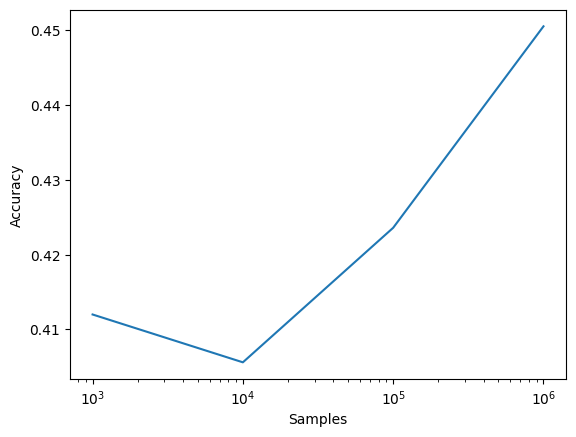

In [42]:
plt.xscale("log")
plt.xlabel("Samples")
plt.ylabel("Accuracy")
plt.plot(samples, accuracies)

In [ ]:
#code

## Method 3 (DP Synthetic Data, Non DP Decision Tree